In [31]:
#import the necessary programming libraries
import torch
#torchvision consists of popular pre established datasets, model architectures, and common image transformations for computer vision.
import torchvision
#transforms the format/size of input images to what the model expects. Could be a crop, flip, normalization, colorization etc 
import torchvision.transforms as transforms
#import image classification neural network, assigns a label to the whole image
import torch.nn as nn
#torch.nn.functional contains useful activation functions
import torch.nn.functional as F

#matplotlib is a plotting library for python
import matplotlib.pyplot as plt
import numpy as np


In [17]:
#Do a transformation of the input/images so that all the data is normalized. The PILimage is transformed from a PILimage with a range of [o.1] to a tensor of normalized range [-1,1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#CIFAR10 is the dataset being used as the input and being classified
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
#num_workers attribute tells the data loader instance how many sub-processes to use for data loading. Essentially this will speed up the time it takes to run each batch of data 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)
#a class is what the data is being identified as 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


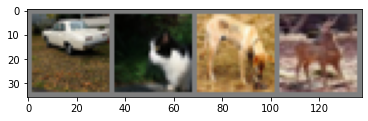

  car   cat   dog  deer


In [32]:
#def imshow creats an image from a 2-dimensional numpy array
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
#getting some random training images    
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show the images
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [20]:
# Define a Convolutional Neural Network: Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined)


#the numbers in parathesis are some sort of parameters, not sure what exactly 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #conv1 applies a 1D convolution over an input signal composed of several input planes
        self.conv1 = nn.Conv2d(3, 6, 5)
        #maxpool2d Applies a 2D max pooling over an input signal composed of several input planes.
        self.pool = nn.MaxPool2d(2, 2)
        #conv2 Applies a 2D convolution over an input image composed of several input planes.
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [21]:
#Define a Loss Function and optimizer: Let’s use a Classification Cross-Entropy loss and SGD with momentum.
#
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [23]:
#Train the Network- This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.232
[1,  4000] loss: 1.237
[1,  6000] loss: 1.212
[1,  8000] loss: 1.202
[1, 10000] loss: 1.205
[1, 12000] loss: 1.182
[2,  2000] loss: 1.117
[2,  4000] loss: 1.126
[2,  6000] loss: 1.131
[2,  8000] loss: 1.098
[2, 10000] loss: 1.123
[2, 12000] loss: 1.098
Finished Training


In [24]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

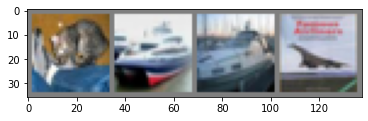

GroundTruth:    cat  ship  ship plane


In [25]:
#Test the network on the test data

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [27]:
outputs = net(images)

#the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


In [29]:
#Let us look at how the network performs on the whole dataset.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


In [30]:
#Find out the classes that performed well, and the classes that did not perform well

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 61 %
Accuracy of  bird : 37 %
Accuracy of   cat : 47 %
Accuracy of  deer : 55 %
Accuracy of   dog : 40 %
Accuracy of  frog : 69 %
Accuracy of horse : 71 %
Accuracy of  ship : 82 %
Accuracy of truck : 76 %
